# Waveome Introduction   
In this notebook we will introduce the core functionality of waveome through a simulated data example.

## Setup

In [1]:
# Libraries
import waveome
from waveome.model_search import GPSearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now let's simulate some longitudinal data. We will have 50 individuals, with 5 observations per individual, and we are interested in 3 outcomes. We will also simulate an auxilary covariate of interest (`female`) to show how waveome handles them.

In [2]:
# Set simulation parameters
n_people = 50
n_observations = 5
total_obs = n_people * n_observations
np.random.seed(9102)

# Get people ID vector
id_vec = np.repeat(np.arange(n_people), repeats=n_observations)

# Simulate time
time_vec = np.random.uniform(low=0, high=10, size=total_obs)

# Simulate auxilary categorical variable
female_vec = np.repeat(
    np.random.choice(a=[0,1], size=n_people), 
    repeats=n_observations
)

# Now outcomes
out1_vec = np.sin(time_vec)
out2_vec = female_vec * np.cos(time_vec)
out3_vec = (#0.25 * time_vec 
            #-1 * (time_vec > 5) * time_vec * female_vec 
            + np.repeat(np.random.normal(size=n_people), repeats=n_observations))

# Add a small amout of random noise to each
out1_vec += np.random.normal(scale=0.5, size=total_obs)
out2_vec += np.random.normal(scale=0.5, size=total_obs)
out3_vec += np.random.normal(scale=0.5, size=total_obs)


# Put it all together in a pandas DataFrame
df = (
    pd.DataFrame(
        {
            'person_id': id_vec,
            'time': time_vec,
            'female': female_vec,
            'outcome1': out1_vec,
            'outcome2': out2_vec,
            'outcome3': out3_vec
        }
    )
    .sort_values(['person_id', 'time'])
    .astype(float)
)

print(f'Dimension of dataset: {df.shape}')

# Show some of the rows
df.head()

Dimension of dataset: (250, 6)


,person_id,time,female,outcome1,outcome2,outcome3
0,0.0,0.979887,0.0,1.727029,1.140400,1.458181
4,0.0,1.536093,0.0,1.214955,0.669612,0.556570
3,0.0,4.198993,0.0,-0.821298,0.707080,2.422259
1,0.0,4.985359,0.0,-0.890540,-0.003830,1.132781
2,0.0,9.846491,0.0,-0.933268,0.762239,1.316444


We can see the first few rows of the simulated data above. Each row is a particular observation at a point in time for a person showing all three outcome values. Now we are going to plot the individual trajectories below for each of the three outcomes. Each line is an individual. We can see that all three outcomes are slightly different, and some do not have much of a disernable pattern right away. 

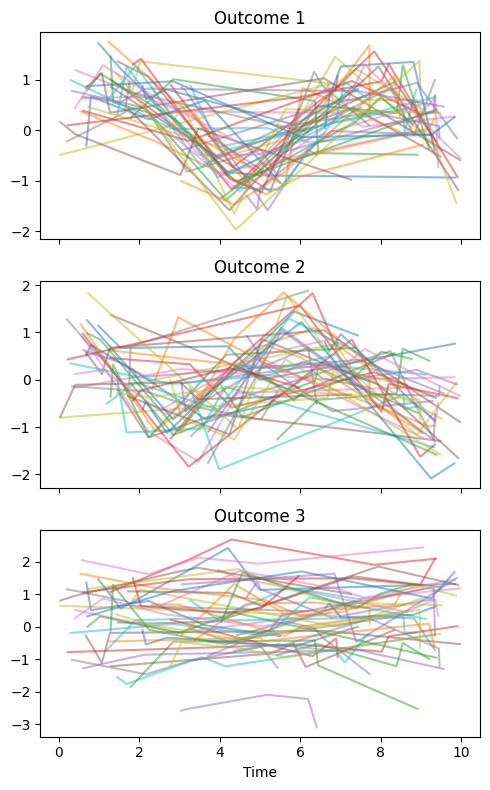

In [3]:
# Plot the data
figs, axs = plt.subplots(3, 1, figsize=(5, 8), sharex=True)
for out in range(1, 4):
    for i in df.person_id.unique():
        axs[(out-1)].plot(
            df.loc[df.person_id == i, 'time'], 
            df.loc[df.person_id == i, 'outcome'+str(out)],
            alpha=0.5
        )
    axs[(out-1)].set_title(f'Outcome {out}')

axs[(out-1)].set_xlabel('Time')
plt.tight_layout()
plt.show()

Now we are going to show the power of wavome, which under the hood is fitting multiple Gaussian process (GP) models to flexible fit the longitudinal data. The `GPSearch` object is the main point of entry for the wavome package. Here is where we point to the dataset and specify the different variable types. Specifically we need to know the covariates (as well as time and individual ID) which will be a Pandas dataframe `X` and the outcome(s) of interest `Y`. Categorical variables must be transformed to floats before running the process, so it might be good to use `pd.factorize()`.

In [4]:
# Load the information into the Gaussian process search object
gps = GPSearch(
    X=df[['person_id', 'time', 'female']],
    Y=df[['outcome1', 'outcome2', 'outcome3']],
    unit_col='person_id',
    categorical_vars=['female'],
    outcome_likelihood='gaussian'
)

In [5]:
# Now run the search process, there are a number of parameters to play
# around with if you are interested - or just run defaults
gps.run_search(
    random_seed=9102,
    # num_jobs=1,
    # verbose=True
)

Kernel search: 100%|██████████| 3/3 [00:23<00:00,  7.73s/it]


Now we have run the search process and found the best models for each of the three outcomes. The next step would be to plot the additive components of each outcome found. We will start with outcome 1. Below we can see that it found one component which is related to time (based on the squared_exponential[time]), and there are some slow-moving dynamics occuring. The right plot shows the leftover residuals that the Gaussian process could not capture. The percentages in the parentheses are estimated variance explained amounts for each component (e.g., 35% of outcome 1 are unaccounted for in the GP).

In [6]:
# Look at the saved object for outcome1
# Can pull off the best model by using: gps.models['outcome1']['models'][gps.models['outcome1']['best_model']]['model']
gps.models["outcome1"]

name,class,transform,prior,trainable,shape,dtype,value
PSVGP.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.19311463]
PSVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.09275
PSVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5942401493089396
PSVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.24280055976820591
PSVGP.inducing_variable.Z,Parameter,Identity,,False,"(250, 3)",float64,"[[0.00000000e+00, -1.46470000e+00, 0.00000000e+00..."
PSVGP.q_mu,Parameter,Identity,,True,"(250, 1)",float64,[[9.44469887e-01...
PSVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 250, 250)",float64,"[[[8.48314043e-02, 0.00000000e+00, 0.00000000e+00..."


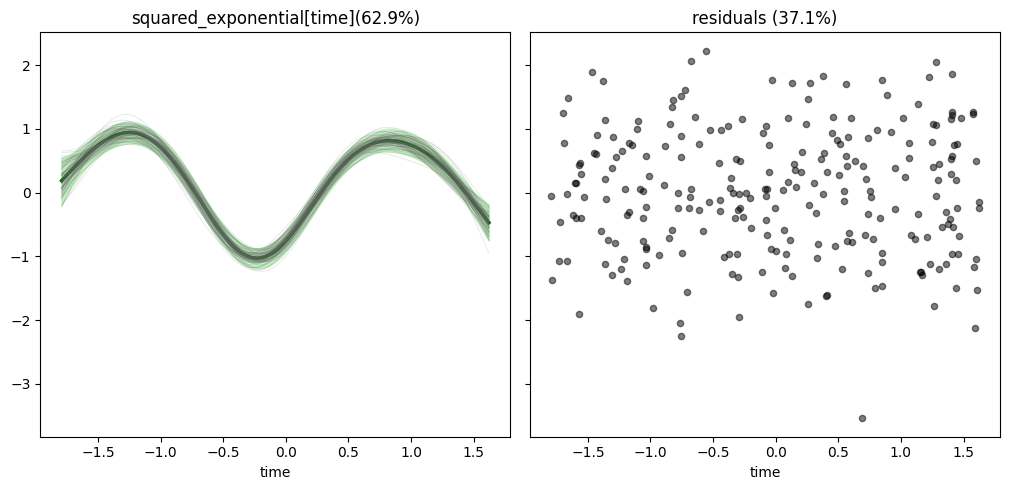

In [7]:
# Now after the search is finished we can inspect the 
# additive components selected for each outcome
gps.plot_parts(
    out_label='outcome1',
    x_axis_label='time'
);

Similarly for outcome 2 we can see our first component found is related to both time and if an individual is a female or not. While for outcome 3 there is an individual-specific effect, as can be seen where each mean prediction line is horizontal across time.

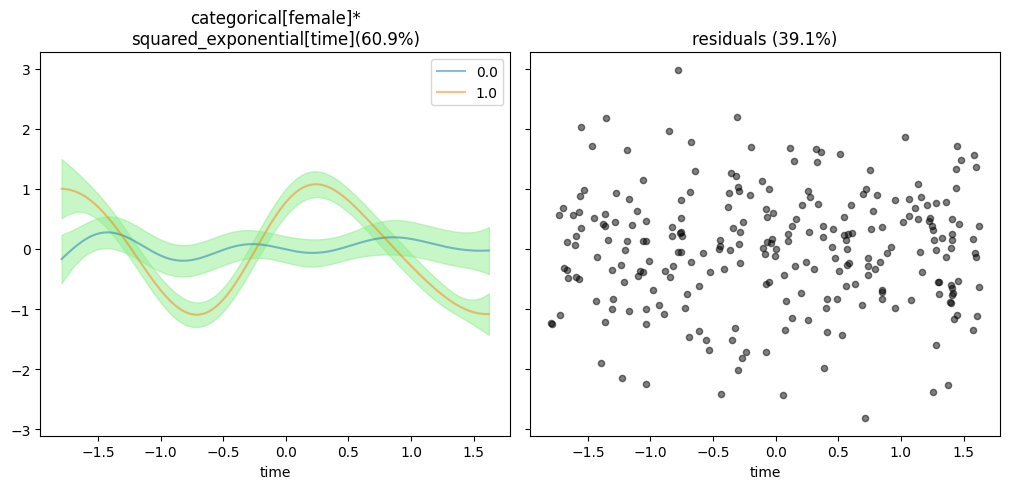

In [8]:
gps.plot_parts(
    out_label='outcome2',
    x_axis_label='time'
);

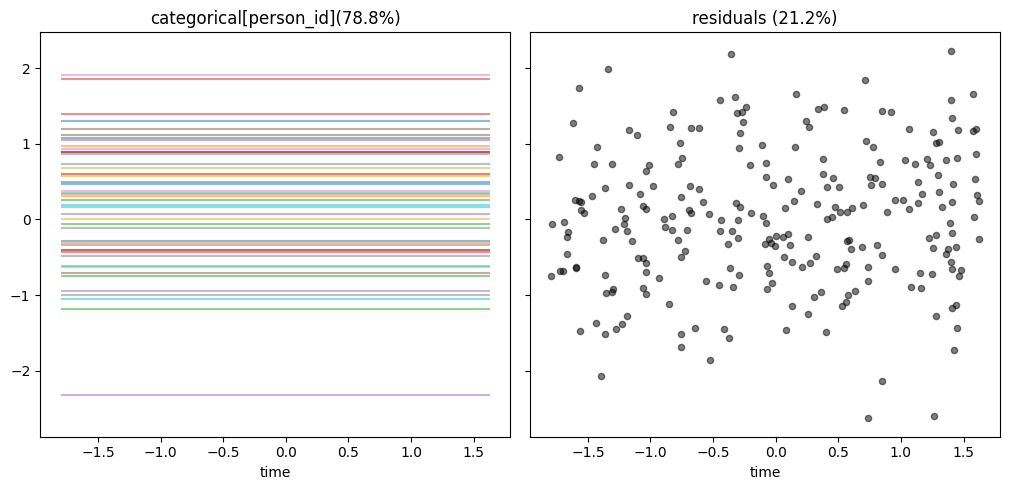

In [9]:
gps.plot_parts(
    out_label='outcome3',
    x_axis_label='time'
);

We can also plot the predicted mean function for a given individual's outcome as well. We show two examples of that below for outcome 2. The first is a non-female while the second is a female. It can be seen that the second one has a more sinusoidal property while the first is more stationary. 

<Axes: xlabel='time'>

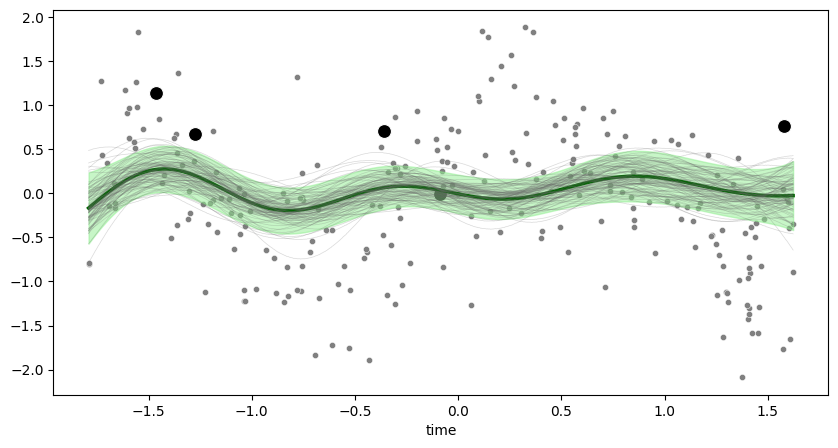

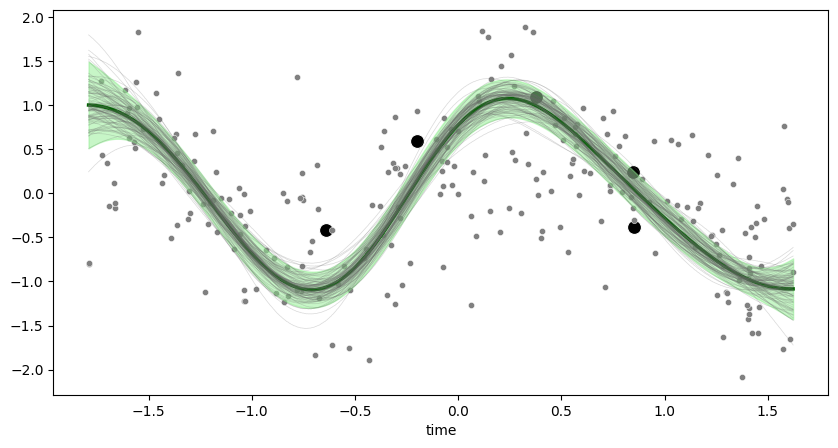

In [10]:
# Plot some of the posterior mean functions for individuals in the dataset
# This is done with the unit_label argument
gps.plot_marginal(
    out_label='outcome2', 
    x_axis_label='time',
    unit_label=0
)

gps.plot_marginal(
    out_label='outcome2', 
    x_axis_label='time',
    unit_label=1
)

Finally, we might be interested in seeing the relationships found between outcomes during the search process. We can view this with a heatmap like the one shown below. Each row is an additive model component, each column is an outcome, and the filled in values are the explained variation of the outcome by that model component.

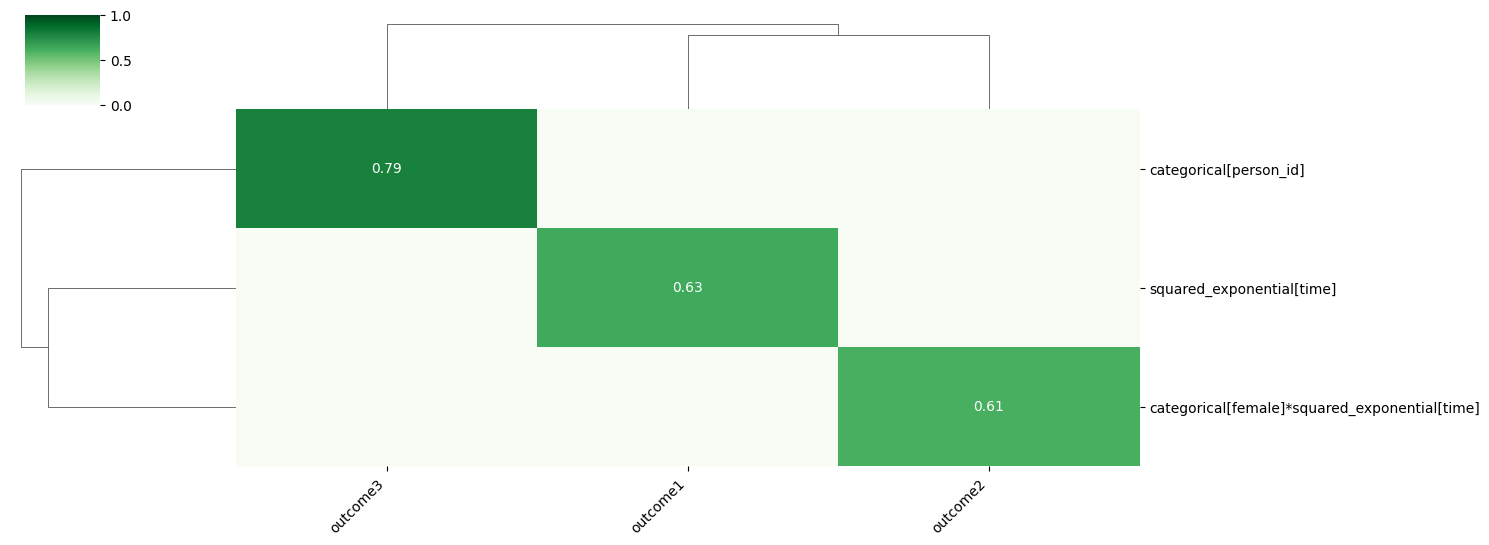

In [11]:
gps.plot_heatmap(var_cutoff=0.1);

From this quick tutorial we have seen how to use waveome to model longitudinal data.